## Import, preprocess and split dataset

In [1]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split

toxic_comments = pd.read_csv("data/train.csv")

filter = toxic_comments['comment_text'] != ""
toxic_comments = toxic_comments[filter]
toxic_comments = toxic_comments.dropna()

def preprocess(s):
    sentence = re.sub('[^a-zA-Z]', ' ', s)
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

X = []
sentences = list(toxic_comments["comment_text"])
for s in sentences:
    X.append(preprocess(s))

y = toxic_comments[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Create individual output for each label

In [2]:
y1_train = y_train[["toxic"]].values
y1_test =  y_test[["toxic"]].values

y2_train = y_train[["severe_toxic"]].values
y2_test =  y_test[["severe_toxic"]].values

y3_train = y_train[["obscene"]].values
y3_test =  y_test[["obscene"]].values

y4_train = y_train[["threat"]].values
y4_test =  y_test[["threat"]].values

y5_train = y_train[["insult"]].values
y5_test =  y_test[["insult"]].values

y6_train = y_train[["identity_hate"]].values
y6_test =  y_test[["identity_hate"]].values

## Vectorize textual feature

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from numpy import asarray, zeros

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

glove_file = open('data/glove.6B.100d.txt', encoding="utf8")

embeddings_dictionary = dict()
for line in glove_file:
    records = line.split()
    word = records[0]
    vector = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector
    
glove_file.close()

vocab_size = len(tokenizer.word_index) + 1

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    vector = embeddings_dictionary.get(word)
    if vector is not None:
        embedding_matrix[index] = vector

Using TensorFlow backend.


## Create model

In [4]:
from keras.layers import Input, LSTM
from keras.layers.embeddings import Embedding
from keras.layers.core import Dense
from keras.models import Model

input_1 = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_1)
LSTM_Layer1 = LSTM(128)(embedding_layer)

output1 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output2 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output3 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output4 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output5 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output6 = Dense(1, activation='sigmoid')(LSTM_Layer1)

model = Model(inputs=input_1, outputs=[output1, output2, output3, output4, output5, output6])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 100)     14824300    input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 128)          117248      embedding_1[0][0]                
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1)            129         lstm_1[0][0]                     
____________________________________________________________________________________________

## Train the model

In [5]:
trained_model = model.fit(x=X_train, y=[y1_train, y2_train, y3_train, y4_train, y5_train, y6_train], batch_size=128, epochs=2, verbose=1, validation_split=0.2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/2
102124/102124 [==============================] - 935s 9ms/step - loss: 0.8789 - dense_1_loss: 0.3180 - dense_2_loss: 0.0641 - dense_3_loss: 0.2101 - dense_4_loss: 0.0301 - dense_5_loss: 0.2000 - dense_6_loss: 0.0565 - dense_1_acc: 0.9041 - dense_2_acc: 0.9898 - dense_3_acc: 0.9473 - dense_4_acc: 0.9965 - dense_5_acc: 0.9508 - dense_6_acc: 0.9915 - val_loss: 0.6621 - val_dense_1_loss: 0.2440 - val_dense_2_loss: 0.0431 - val_dense_3_loss: 0.1546 - val_dense_4_loss: 0.0198 - val_dense_5_loss: 0.1511 - val_dense_6_loss: 0.0489 - val_dense_1_acc: 0.9047 - val_dense_2_acc: 0.9901 - val_dense_3_acc: 0.9472 - val_dense_4_acc: 0.9967 - val_dense_5_acc: 0.9511 - val_dense_6_acc: 0.9902
Epoch 2/2
102124/102124 [==============================] - 433s 4ms/step - loss: 0.4296 - dense_1_loss: 0.1617 - dense_2_loss: 0.0291 - dense_3_loss: 0.0891 - dense_4_loss: 0.0166 - dense_5_loss: 0.0981 - dense_6_loss: 0.0350 - dense_1_acc: 0.9450 - dens

## Evaluate the model

In [6]:
score = model.evaluate(x=X_test, y=[y1_test, y2_test, y3_test, y4_test, y5_test, y6_test], verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

31915/31915 [==============================] - 54s 2ms/step
Test Score: 0.3653215220481386
Test Accuracy: 0.13059894740581512


## Plot loss and accuracy

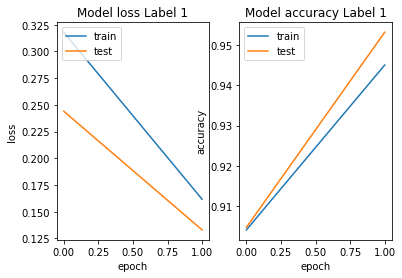

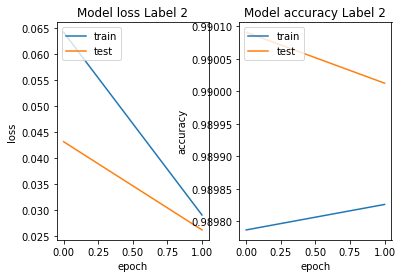

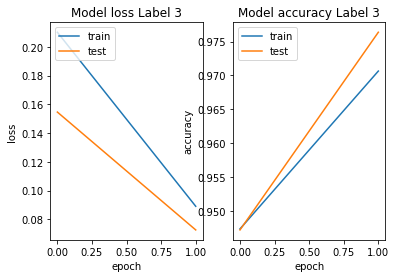

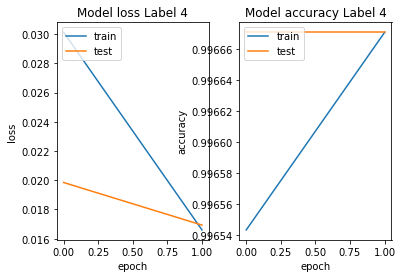

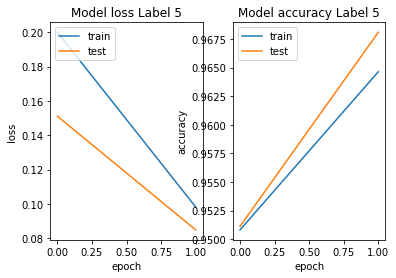

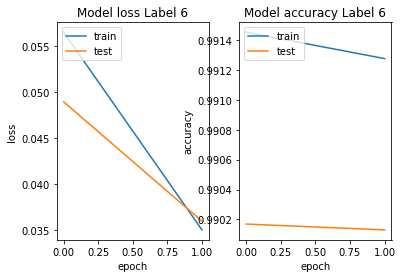

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.subplot(1,2,1)
plt.plot(trained_model.history['dense_1_loss'])
plt.plot(trained_model.history['val_dense_1_loss'])
plt.title('Model loss Label 1')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.subplot(1,2,2)
plt.plot(trained_model.history['dense_1_acc'])
plt.plot(trained_model.history['val_dense_1_acc'])
plt.title('Model accuracy Label 1')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.figure()
plt.subplot(1,2,1)
plt.plot(trained_model.history['dense_2_loss'])
plt.plot(trained_model.history['val_dense_2_loss'])
plt.title('Model loss Label 2')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.subplot(1,2,2)
plt.plot(trained_model.history['dense_2_acc'])
plt.plot(trained_model.history['val_dense_2_acc'])
plt.title('Model accuracy Label 2')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.figure()
plt.subplot(1,2,1)
plt.plot(trained_model.history['dense_3_loss'])
plt.plot(trained_model.history['val_dense_3_loss'])
plt.title('Model loss Label 3')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.subplot(1,2,2)
plt.plot(trained_model.history['dense_3_acc'])
plt.plot(trained_model.history['val_dense_3_acc'])
plt.title('Model accuracy Label 3')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.figure()
plt.subplot(1,2,1)
plt.plot(trained_model.history['dense_4_loss'])
plt.plot(trained_model.history['val_dense_4_loss'])
plt.title('Model loss Label 4')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.subplot(1,2,2)
plt.plot(trained_model.history['dense_4_acc'])
plt.plot(trained_model.history['val_dense_4_acc'])
plt.title('Model accuracy Label 4')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.figure()
plt.subplot(1,2,1)
plt.plot(trained_model.history['dense_5_loss'])
plt.plot(trained_model.history['val_dense_5_loss'])
plt.title('Model loss Label 5')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.subplot(1,2,2)
plt.plot(trained_model.history['dense_5_acc'])
plt.plot(trained_model.history['val_dense_5_acc'])
plt.title('Model accuracy Label 5')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.figure()
plt.subplot(1,2,1)
plt.plot(trained_model.history['dense_6_loss'])
plt.plot(trained_model.history['val_dense_6_loss'])
plt.title('Model loss Label 6')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.subplot(1,2,2)
plt.plot(trained_model.history['dense_6_acc'])
plt.plot(trained_model.history['val_dense_6_acc'])
plt.title('Model accuracy Label 6')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [12]:
import pickle

filename = 'model_multi_output.sav'
pickle.dump(model, open(filename, 'wb'))